# Masked Langauge Modelling (MLM)

https://www.youtube.com/watch?v=q9NS5WpfkrU

- MLM is one of the tasks that the BERT model is trained on

- The other task is next-sentence prediction, which we will go through later

## Basic Idea

- You have some input sentence "The quick brown fox jumps over the lazy dog"

- Post tokenization, your sentence will look like an array of integers 

- Of these integers, select a proportion to mask. That means: replace a random proportion of integers with a fixed integer representing "[MASK]". BERT replaces ~15% of tokens this way

- Then, your loss function function is simply the cross entropy loss over the masked tokens. For details, see section on `cross_entropy.ipynb` under the Data Science repo

$$\begin{aligned}
    \mathcal{L} &= - \sum_{i \in \text{mask index}} \log (P(x_i | x_{\text{mask}}))
\end{aligned}$$

## BERT Architecture

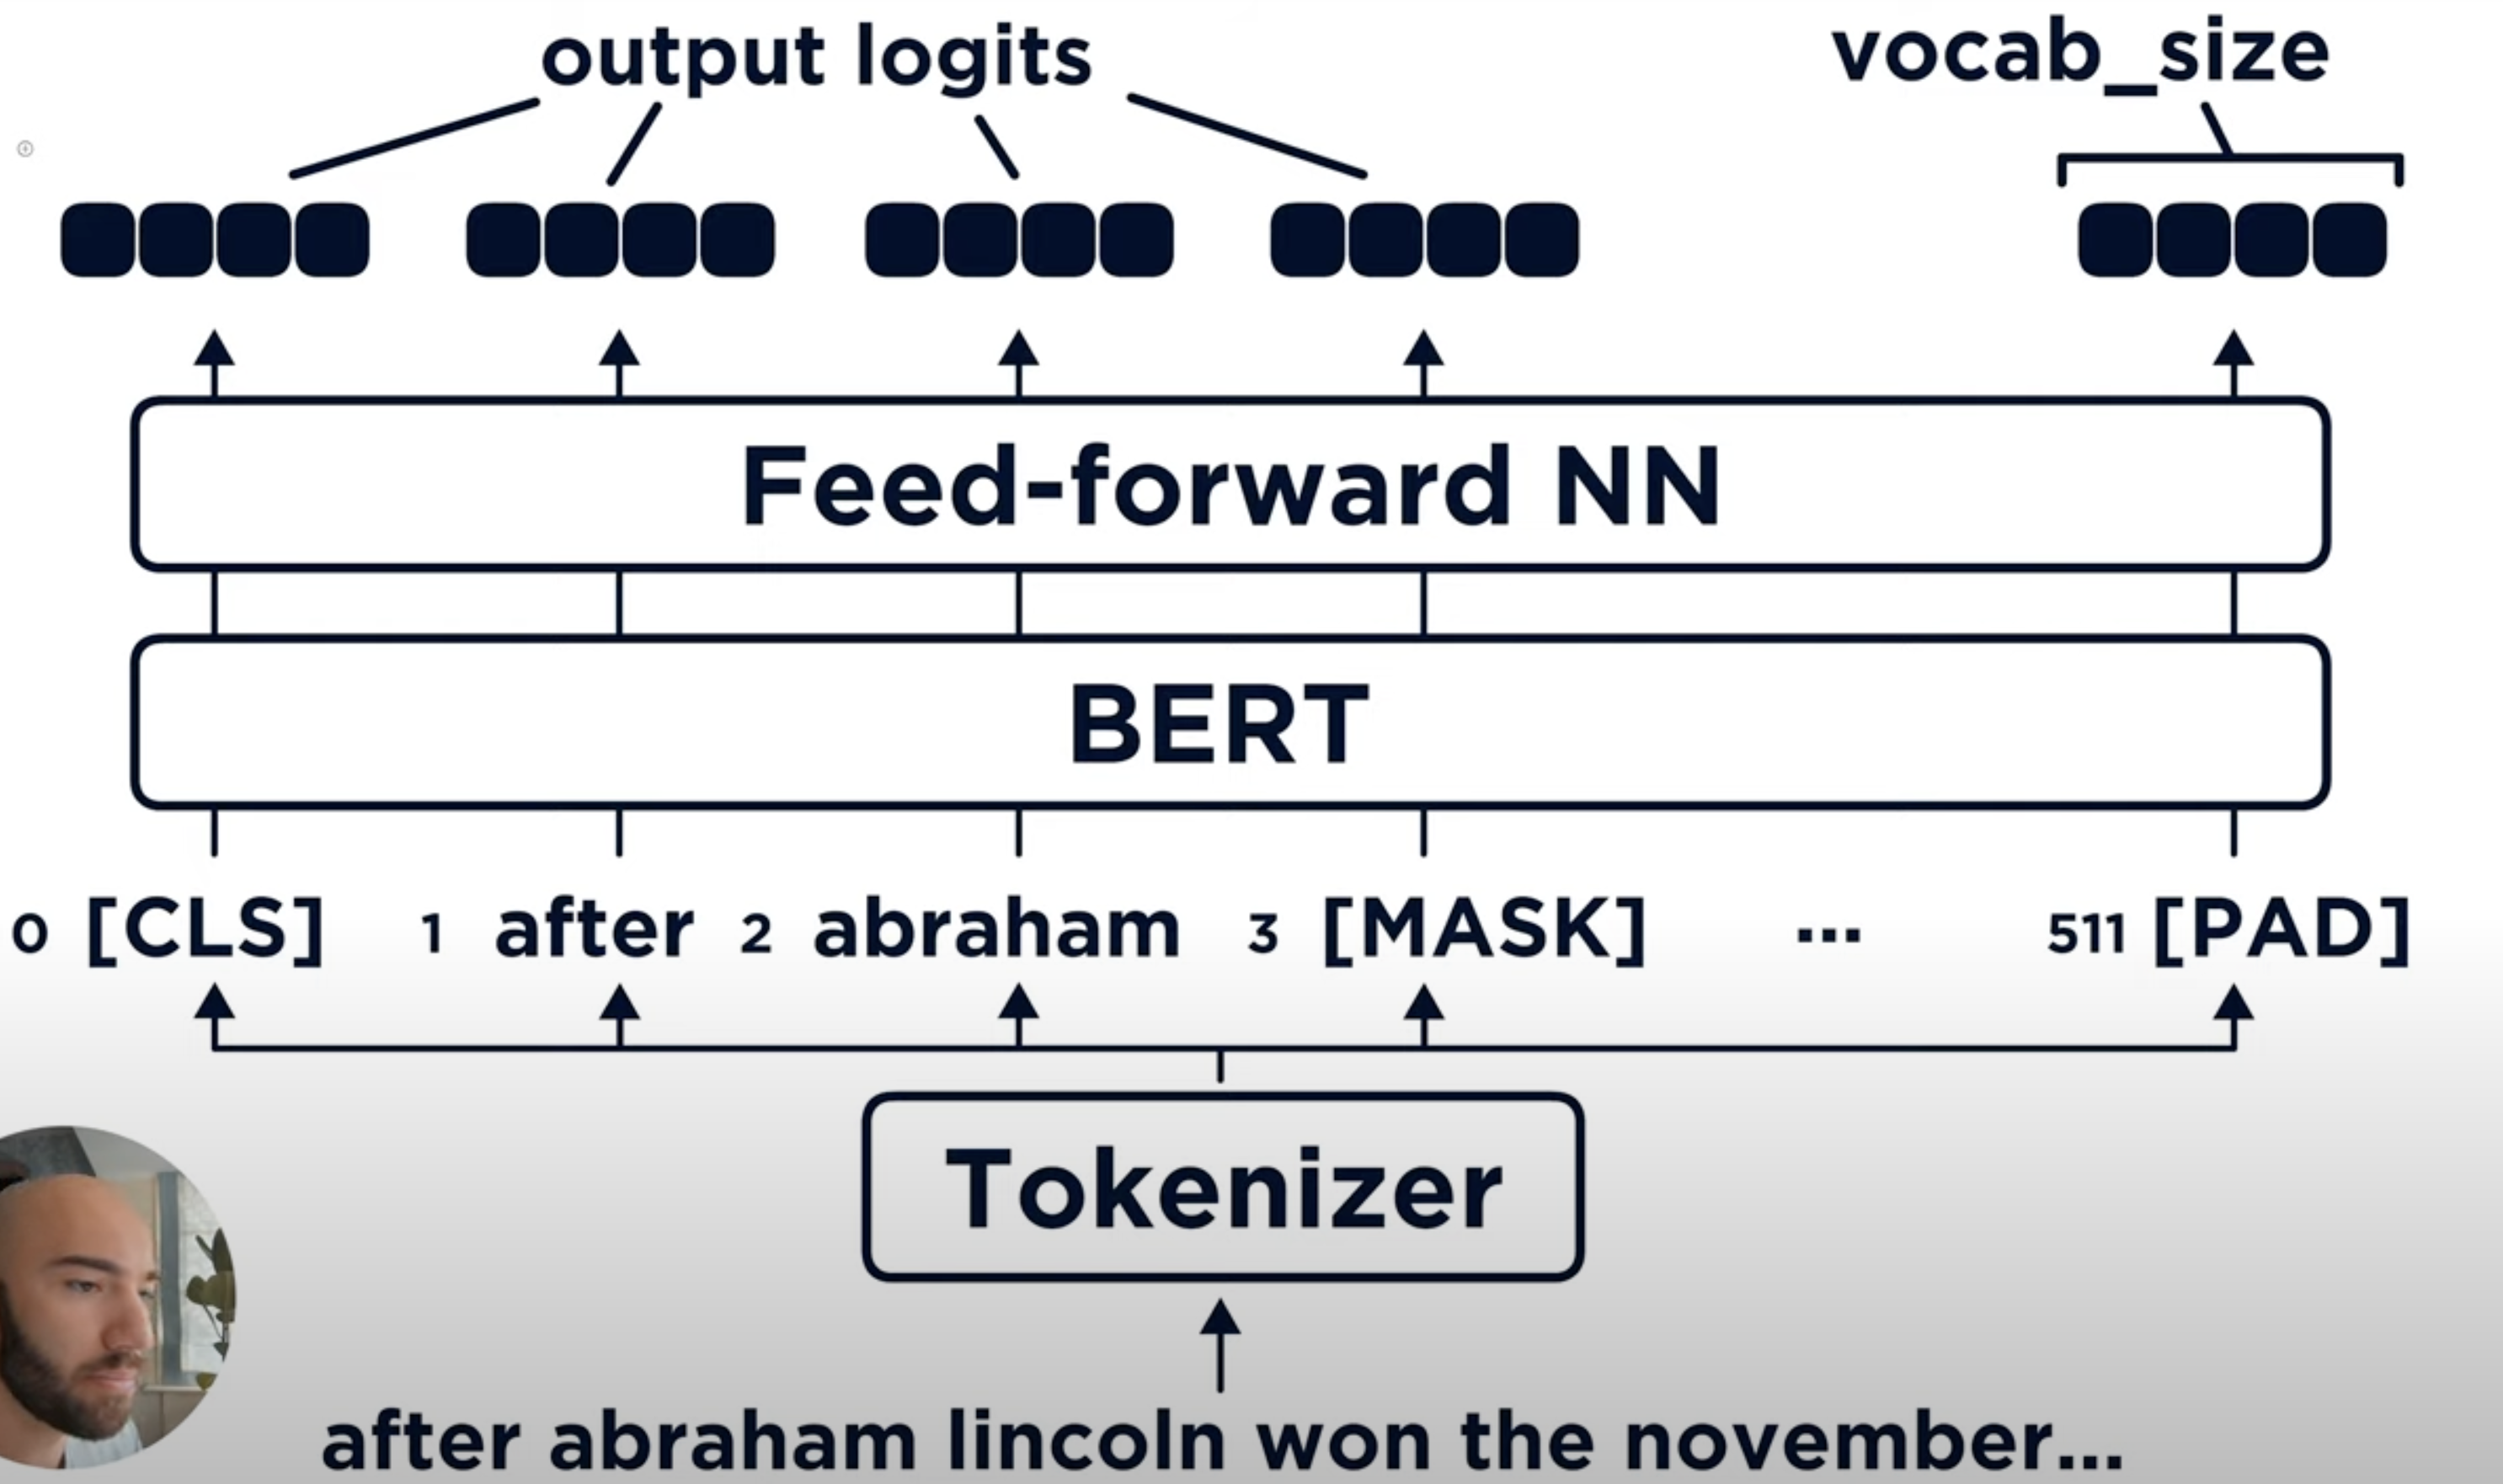

- Broad explanation of each step
    1. Pass in a string to BERT as the input
    2. String gets tokenized. You can use any form of tokenisation, but BERT uses WordPiece tokenization (i.e. subword tokenizer)
    3. Each word piece is now represented as an integer, with each integer representation a subword. The integers index into an embedding matrix, which in this case is handwaved away as part of the `BERT` layer
    4. The tokenised string gets passed into a masking layer, which randomly masks out / replaces some word BERT masks about 15% of the input string as the `[MASK]` token, and ~10% as a random token (to avoid overreliance on `[MASK]`)
    5. Then, the sequence of integers gets passed into BERT. The detailed architecture of BERT is not so important, just know that $N$ integers representing subwords go in, and an intermediate layer of $N \times 768$ vectors come out
    6. These intermediate vectors are passed on to a standard feed-forward neural net
    7. For each $N$ position of the initial string, there are `vocab_size` possibilities. 
    8. The network outputs a raw value for each of these options (i.e. logits), a softmax is applied to normalise these logits into a probability distribution, and an argmax is used to find the most likely token for that position
    9. We compute loss using cross entropy, and run backpropagation

### MLM 

In [1]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

In [34]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
text = ("""
    The rain had stopped just before dawn, leaving the streets coated in a thin silver sheen. A cat darted across the alley, pausing briefly to eye the half-open bakery door. Inside, the smell of warm bread mixed with the faint hum of an old refrigerator, filling the quiet with a strange sense of anticipation.     
""")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [35]:
inputs = tokenizer(text, return_tensors='pt')
print(inputs.data.keys())
inputs.data['input_ids']

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


tensor([[  101,  1996,  4542,  2018,  3030,  2074,  2077,  6440,  1010,  2975,
          1996,  4534, 15026,  1999,  1037,  4857,  3165, 20682,  1012,  1037,
          4937, 14051,  2408,  1996,  8975,  1010, 20490,  4780,  2000,  3239,
          1996,  2431,  1011,  2330, 18112,  2341,  1012,  2503,  1010,  1996,
          5437,  1997,  4010,  7852,  3816,  2007,  1996,  8143, 14910,  1997,
          2019,  2214, 18097,  1010,  8110,  1996,  4251,  2007,  1037,  4326,
          3168,  1997, 11162,  1012,   102]])

In [44]:
inputs.data['labels'] = inputs.data['input_ids'].detach().clone()
inputs.data;

In [51]:
rand = torch.rand(inputs.data['input_ids'].shape)

In [52]:
mask_arr = rand < 0.15

In [55]:
(inputs.data['input_ids'] != 101) * (inputs.data['input_ids'] != 102) * (rand <= 0.15)

tensor([[False, False, False, False, False, False, False, False, False, False,
         False,  True, False, False, False, False, False, False, False, False,
          True, False, False, False,  True,  True, False,  True, False, False,
          True, False,  True, False, False,  True, False, False, False,  True,
         False, False, False, False, False,  True, False, False, False, False,
         False, False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False]])